In [1]:
import numpy as np
import environment
import model

n_agents = 2
env = environment.CommonPoolEnv(model.DEFAULT_MAP, n_agents)
observations, *_ = env.reset()
observation = observations[0]

/home/rosa/.local/lib/python3.10/site-packages/anaconda3/envs/cgt-project-example/lib/python3.8/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


1) EXPERIENCE REPLAY:
   randomizes over the data, thereby removing correlations in the observation sequence and smoothing over changes in the data distribution
2) Iterative update:
   adjust tge action-values (Q) towards target values that are only periodically updated, thereby reducing the correlations with the target
   Dit betekend dat de target DQN pas om de zoveel iteraties wordt geupdate. Het training DQN elke keer (zo neem ik het aan)

In [4]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cpu


Ben aan de hand hiervan beginnen proberen
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity, minibatch_size=32):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))
        self._index = (self._index + 1)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def current_index(self):
            return self._index

    def get_minibatch_indices(self):
            indices = []
            while len(indices) < minibatch_size:
                index = np.random.randint(low=0, high = self.current_index, dtype=np.int32)
                indices.append(index)

    def generate_minibatch_samples(self, indices):
        state_batch, action_batch, next_state_batch, reward_batch = [], [], [], []
    
        for index in indices:
            selected_mem = self._memory[index]
            state_batch.append(torch.tensor(selected_mem.state, dtype=torch.float32))
            action_batch.append(torch.tensor(selected_mem.action, dtype=torch.int32))
            next_state_batch.append(torch.tensor(selected_mem.next_state, dtype=torch.float32))
            reward_batch.append(torch.tensor(selected_mem.reward, dtype=torch.float32))
            
        return torch.stack(state_batch, dim=0), torch.stack(action_batch, dim=0), torch.stack(next_state_batch, dim=0), torch.stack(reward_batch, dim=0)

        
                

Hier beetje aan het prutsen geweest met CNN, maar wou nu eerst DQN te laten werken door gewoon te flatten en zo te trainen

In [6]:
input_size = 3 * environment.OBSERVE_WIDTH_VIEW * environment.OBSERVE_FRONT_VIEW
kernel_size = 5
stride = 1
padding = 0
output_size = ((input_size - kernel_size + 2 * padding) / stride) + 1
output_size

1256.0

In [7]:
input_size = output_size
kernel_size = 5
stride = 1
padding = 0
output_size = ((input_size - kernel_size + 2 * padding) / stride) + 1
output_size

1252.0

In [4]:
class CnnDQN(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=model.N_ACTIONS):
        super(DQN, self).__init__()

        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        
        self.layer1 = nn.Linear(412, hidden_size)    # Input Layer
        self.layer2 = nn.Linear(hidden_size, hidden_size)   # Hidden layer 1
        self.layer3 = nn.Linear(hidden_size, hidden_size)   # Hidden Layer 2
        self.layer4 = nn.Linear(hidden_size, output_size)   # Output Layer

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)


In [8]:
# DQN zoals in onze paper staat

class DQN(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=model.N_ACTIONS):
        super(DQN, self).__init__()
        
        self.layer1 = nn.Linear(input_size, hidden_size)    # Input Layer
        self.layer2 = nn.Linear(hidden_size, hidden_size)   # Hidden layer 1
        self.layer3 = nn.Linear(hidden_size, hidden_size)   # Hidden Layer 2
        self.layer4 = nn.Linear(hidden_size, output_size)   # Output Layer

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)


In [28]:
memory = ReplayMemory(10000)

In [15]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

BATCH_SIZE = 32    # Minibatch size
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 10000  #LINEARLY OVER TIME?
LR = 0.00025 # from paper human action

n_actions = env.action_space.n
observation = env.reset()

n_observations = len(observation[0])

policy_net = DQN(363).to(device)
target_net = DQN(363).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer1 = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
# Policy van paper is RMSPROP
#optimizer = optim.RMSProp(policy_net.parameters(),lr=LR, momentum=0.95,...)


memory = ReplayMemory(10000) # Paper Human... has it on 1 000 000

steps_done = 0

def select_action(state, epsilon):
    global steps_done
    if random.random() > epsilon:
        with torch.no_grad():
            return policy_net(state) # tensor([-0.0620,  0.0564,  0.0095, -0.1008, -0.2029,  0.1698,  0.1158, -0.1945]) argmax ofzo hier nog
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


In [39]:
action = torch.tensor([[env.action_space.sample()]])
nObservations, nRewards, nDone, nInfo = env.step(action)

In [48]:
print(f"action {action}")
nObservations[0]

action tensor([[7]])


array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.74901961, 0.74901961, 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.74901961, 0.74901961, 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        ,

In [ ]:
def ReplayMemory

In [32]:
# TRAINING
total_steps = 0
episode = 0

nStates = env.reset()
while total_step < training_steps
    
    state_agent0 = torch.tensor(nStates[0], dtype=torch.float32, device=device).unsqueeze(0)
    flatten_state = torch.flatten(state_agent0)

    epsilon = 1

    action = select_action(flatten_state, epsilon)
    next_state, reward, done, info = env.step(action)
    episode_score += reward[0]
    # memory = ('state', 'action', 'next_state', 'reward'))
    memory.push(nStates[0], action, next_state[0], reward[0])
    nStates = next_state

    
    if (total_step % update_frequency == 0):
        

ValueError: Sample larger than population or is negative

In [53]:
n_actions

8

In [9]:
obs = env.reset()
state = torch.tensor(obs[0], dtype=torch.float32, device=device).unsqueeze(0)

In [10]:
flatten_state = torch.flatten(state)

In [16]:
flatten_state.shape

torch.Size([363])

In [24]:
act = policy_net(flatten_state)

In [25]:
act

tensor([-0.0620,  0.0564,  0.0095, -0.1008, -0.2029,  0.1698,  0.1158, -0.1945],
       grad_fn=<ViewBackward0>)

In [23]:
np.argmax(policy_net(flatten_state)

AttributeError: 'Tensor' object has no attribute 'tonumpy'

In [18]:
act

tensor([-0.0620,  0.0564,  0.0095, -0.1008, -0.2029,  0.1698,  0.1158, -0.1945],
       grad_fn=<ViewBackward0>)

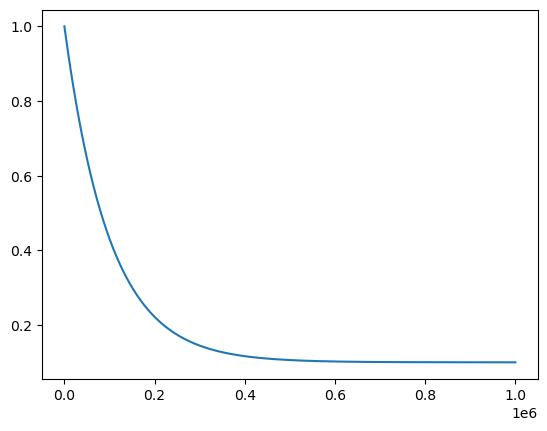

In [41]:
epsilon_S = 1.0
epsilon_E = 0.1
epsilon_decay = 100000

_epsilon = lambda frame: epsilon_E + (epsilon_S - epsilon_E)*np.exp(-frame/epsilon_decay)
plt.plot([_epsilon(frame) for frame in range(1000000)]);

In [36]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [37]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state[0], dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

NameError: name 'eps' is not defined

In [30]:
torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

tensor([[5]])

In [25]:
nObs[0]

array([[[0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078]],

       [[0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078]],

       [[0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.70196078, 0.70196078],
        [0.70196078, 0.7019607

### Human Level Control ###
Hier even iets anders geprobeerd maar zit nu even in between both of hier op verder of op vorige, of combinatie
https://github.com/jihoonerd/Human-level-control-through-deep-reinforcement-learning/blob/master/dqn/agent/dqn_agent.py

In [ ]:
def get_action(state, epsilon):
    if random.random() < epsilon:
        q_value = policy_net(state).max(1)
        return policy_net(state).max(1).indices.view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [ ]:
class Agent:
    def __init__(self, env="CommonsGame:CommonsGame-v0"):
        self.game_id = env
        self.env = Environment(self.game_id, train=True)
        self.discount_factor = 0.99
        self.minibatch_size = 32
        self.update_frequency = 4
        self.target_network_update_freq = 1000
        self.agent_history_length = 4
        self.memory = ReplayMemory(capacity=10000, minibatch_size=self.minibatch_size)
        self.main_network = DQN(num_actions=self.env.get_action_space_size(), hidden_size=32, output_size=8)
        self.target_network = DQN(num_actions=self.env.get_action_space_size(), hidden_size=32, output_size=8)
        self.optimizer = optimizer
        self.init_epsilon = 1.0
        self.final_epsilon = 0.1
        self.final_explr_frame = 1000000 # nog bepalen
        self.replay_start_size = 10000 # nog geen idee wat dit is
        self.loss = tf.keras.losses.Huber()
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.q_metric = tf.keras.metrics.Mean(name="Q_value")
        self.training_frames = int(1e7)
        self.log_path = "./log/" + datetime.now().strftime("%Y%m%d_%H%M%S") + "_" + self.game_id
        self.summary_writer = tf.summary.create_file_writer(self.log_path + "/summary/")
        self.life_game = None
        self.print_log_interval = 10
        self.save_weight_interval = 10

        self.env.reset()
        _, _, _, info = self.env.step(0)
        if info["ale.lives"] > 0:
            self.life_game = True
        else:
            self.life_game = False   
    